tensor([[-0.9731, -1.0457, -0.7276, -1.0712],
        [ 0.8491,  0.7041,  1.1134,  0.7340],
        [ 0.7871,  0.6000,  0.8542,  0.9942],
        [ 0.1452,  0.2928,  0.5349,  0.7256],
        [ 1.0121,  0.9064,  0.9701,  0.4628],
        [-0.5968, -0.7784, -0.8167, -0.2609],
        [-0.5017, -0.6705, -0.6731, -0.5282],
        [ 0.3821,  0.7214,  0.4022,  0.5457],
        [-0.2620, -0.5324, -0.6004, -0.5247],
        [-0.7276, -1.0712, -0.4529, -0.9853]]) tensor([[-0.4529],
        [ 0.9548],
        [ 1.0493],
        [ 0.4118],
        [ 0.8237],
        [-0.3351],
        [-1.0005],
        [ 1.0047],
        [-0.6536],
        [-0.5126]])


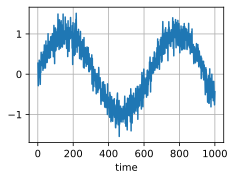

In [49]:
#数据生成
import torch
from d2l import torch as d2l
from torch import nn
T=1000
times= torch.arange(1,T+1)
data=torch.sin(times*0.010)+torch.normal(0,0.2,times.shape)
d2l.plot(times,data,'time')
tau=4
#这么写 第一位不是样本数
#labels=torch.tensor([data[i+tau] for i in range(T-tau)])
labels=data[tau:].reshape((-1,1))
features=torch.zeros((T-tau,tau))
for i in range(tau):
  features[:,i]=data[i:T-tau+i]
batch_size=10
n_train=600
train_iter=d2l.load_array((features[:n_train],labels[:n_train]),batch_size=batch_size)
for x,y in train_iter:
  print(x,y)
  break
#d2l.plot([times,times[tau:]],[data,])


In [50]:
#训练
def init_weight(m):
  if type(m)==nn.Linear:
    nn.init.xavier_uniform_(m.weight)

def get_net():
  net=nn.Sequential(nn.Linear(4,10),nn.ReLU(),nn.Linear(10,1))
  net.apply(init_weight)
  return net

net=get_net()
loss=nn.MSELoss(reduction='none')
trainer=torch.optim.Adam(net.parameters(),lr=0.01)
epoch_num=5
for epochs in range(epoch_num):
  for x,y in train_iter:
    trainer.zero_grad()
    l=loss(net(x),y)
    l.sum().backward()
    trainer.step()
  print(f'loss={d2l.evaluate_loss(net,train_iter,loss)}')



loss=0.05764128091434638
loss=0.05533346931139628
loss=0.05888915439446767
loss=0.05356808538238207
loss=0.053854620506366094


torch.Size([996, 1])


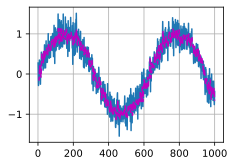

In [51]:
#print(net(features).resize((1,-1)).shape)
#d2l.plot(times[:n_train],(data[n_train],net(features).reshape(1,-1)[:n_train]))
#torch.Size([1000]) and torch.Size([996, 1])
print(net(features).shape)
d2l.plot([times,times[tau:]],[data,net(features).detach().numpy()])

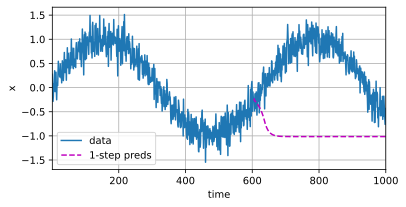

In [52]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = data[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([times, times[n_train + tau:]],
         [data.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

这里用了一个矩阵来表示k-step，y轴往下代表时间，x轴往右代表开始时间点。

所谓k-step指从tau个真实值后k开始预测，k等于1等价于直接从tau个真实值预测，k等于2会包含一个预测值，k=5包含4个预测值，k=64是从预测了63次的值转移来的

(933,)


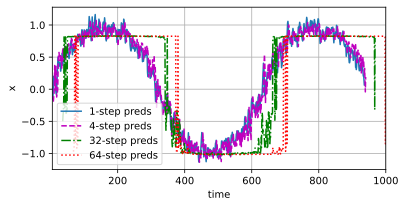

In [57]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = data[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 32, 64)
d2l.plot([times[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

print(features[:, 50].detach().numpy().shape)